# Physical activity monitoring project - ML model traning



.\start_notebook.bat

---

# Activity_Classification_PAMAP2_MiniRocket_RidgeClassifier

---

In [5]:
import os, glob, re, random
import numpy as np
import pandas as pd
import joblib
import json
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
import math
import os
from collections import Counter
from sklearn.model_selection import train_test_split

from sktime.transformations.panel.rocket import MiniRocket
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [6]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Unique activities: {3, 5, 6, 7}
Activity counts: Counter({3: 195, 6: 169, 7: 94, 5: 64})
Minimum samples per activity: 64
Training samples: 204
Testing samples: 52
Training activity counts: Counter({5: 51, 6: 51, 7: 51, 3: 51})
Testing activity counts: Counter({6: 13, 3: 13, 5: 13, 7: 13})
['C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_34.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_6_chunk_72.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_3.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_7_chunk_28.csv', 'C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1\\subject101_activity_5_chunk_9.csv']
[5, 6, 5, 7, 5]
Labels list: ['Standing', 'Running', 'Cycling', 'Nordic walking']


(204, 100, 43)
(52, 100, 43)
(204, 43, 100)
(52, 100, 43)
(204, 504)
Test score: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        13

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

Accuracy: 1.0


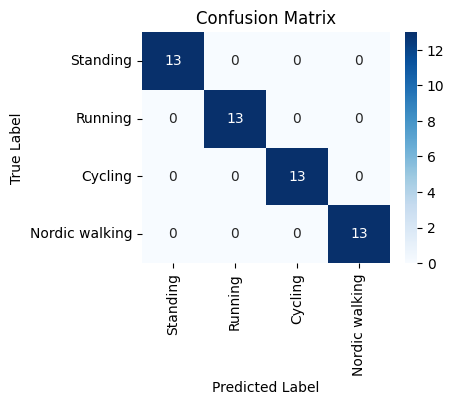

Model saved to c:\Users\malit\Documents\GitHub\AI_ML\physical-activity-monitoring-api\models\ridge_classifier.joblib
Scaler saved to c:\Users\malit\Documents\GitHub\AI_ML\physical-activity-monitoring-api\models\scaler.joblib
Transformer saved to c:\Users\malit\Documents\GitHub\AI_ML\physical-activity-monitoring-api\models\minirocket_transformer.joblib


accuracy,▁
accuracy,1
classification_report,precis...


In [9]:
# Create Datasets


# Define the path to your data folder
folder_path = r"C:\Users\malit\Documents\GitHub\AI_ML_data\PAMAP2_Dataset\activity_chunks_v1"

# Define the activities you want to include in the dataset
selected_activities = {3, 5, 6, 7} # Example: select activities 3, 6, and 7

# Get a list of all csv files for subject101
all_files = glob.glob(os.path.join(folder_path, "subject101*.csv"))

X_list = []
y_list = []

# There is 4 activity classes in the dataset, 3, 5, 6, 7
# Loop through each file and extract the activity ID and file path
for file_path in all_files:
    # 1. Parse the activity ID from the filename
    # This uses a regular expression to find the number after "activity_"
    match = re.search(r"activity_(\d+)", os.path.basename(file_path))
    if not match:
        continue # Skip files that don't match the pattern
    
    activity_id = int(match.group(1))

    # Only include files from the selected activities
    if activity_id not in selected_activities:
        continue
    
    # 2. Append the file path and activity ID to the lists
    X_list.append(file_path)
    y_list.append(activity_id)

# list unique activity IDs
unique_activities = set(y_list)
print("Unique activities:", unique_activities)

# number of samples per activity
activity_counts = Counter(y_list)
print("Activity counts:", activity_counts)

# get the minimum number of samples across all activities
min_samples = min(activity_counts.values())
print("Minimum samples per activity:", min_samples)

# create list of min_samples for each activity
balanced_y_list = []
balanced_X_list = []

for activity in unique_activities:
    # get all indices for this activity
    indices = [i for i, x in enumerate(y_list) if x == activity]
    # randomly select min_samples indices
    selected_indices = random.sample(indices, min_samples)
    # append the selected samples to the balanced lists
    for idx in selected_indices:
        balanced_y_list.append(y_list[idx])
        balanced_X_list.append(X_list[idx])

# separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(balanced_X_list, balanced_y_list, test_size=0.2, stratify=balanced_y_list, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training activity counts:", Counter(y_train))
print("Testing activity counts:", Counter(y_test))

print(X_train[:5])
print(y_train[:5])

# ===========================================================================
# Finishd creating dataset for subject101 only
# Now, we will create a W&B artifact to log this dataset information
# This artifact will include metadata about the dataset, such as the number of samples, features, and classes.

activity_list = [ "Lying", "Sitting", "Standing", "Walking", "Running", "Cycling", "Nordic walking", "Watching TV", "Computer work", "Car driving", "Ascending stairs", "Descending stairs", "Vacuum cleaning", "Ironing", "Folding laundry", "House cleaning", "Playing soccer", "Rope jumping"]

# create labels list according to selected_activities

labels_list = []
for activity_id in selected_activities:
    if 1 <= activity_id <= len(activity_list):
        labels_list.append(activity_list[activity_id - 1]) # -1 for zero-based index
    else:
        labels_list.append(f"activity_{activity_id}") # fallback label

print("Labels list:", labels_list)


# TODO: change the values as per requirement
activities_description = "Initial version of the dataset. No features removed. Testing with subject101 only. Test/train split 80/20, balanced classes. only activities 3, 5, 6 and 7 included. Second try"
values_alphas = [-3, 3, 10]

number_of_kernels = 512

alphas = np.logspace(values_alphas[0], values_alphas[1], values_alphas[2])
project_name = "Activity_Classification_PAMAP2_MiniRocket_RidgeClassifier"
dataset_name = f"PAMAP2_subject101_balanced_activities_{'_'.join(map(str, sorted(selected_activities)))}"



# 2. Create a W&B artifact for the dataset

run = wandb.init(
    project=project_name,
    job_type=dataset_name,
    # Track hyperparameters and run metadata
    dir="https://github.com/malithjkd/AI_ML/blob/main/Physical_activity_monitoring/3_model_traning_v3.ipynb",
    config={
        "number of classes": len(labels_list),
        "transformer": "MiniRocket",
        "classifier": "RidgeClassifierCV",
        "num_kernels": number_of_kernels,
        "alphas": alphas,
        "alphas_values": values_alphas,
        "dataset": "basic_motions",
        "notes": "Example of using MiniRocket with RidgeClassifierCV on multivariate time series data",
        "labels": labels_list,
    }
    )


# Structured metadata for tracking and comparison
dataset_metadata = {
    "num_training_samples": len(X_train),
    "num_testing_samples": len(X_test),
    "num_features": len(X_train[0]) if X_train else 0,
    "features": list(range(len(X_train[0]))) if X_train else [],
    "data_source": "PAMAP2_Dataset\\activity_chunks_v1",
    "activities_included": selected_activities,
}

# Create an artifact to act as a reference
dataset_artifact = wandb.Artifact(
    name='PAMAP2_subject101_balanced_activities_3_6_dataset',
    type='dataset',
    description=activities_description,
    metadata=dataset_metadata
)
run.log_artifact(dataset_artifact)



# open csv files and load data into numpy arrays remove column 0 and 1 (timestamp and activity ID)
def load_data(file_paths):
    data_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, header=None)
        # remove column 0 and 1
        df = df.drop(columns=[0, 1])
        data_list.append(df.values)
    return np.array(data_list)


X_train_data = load_data(X_train)
print(X_train_data.shape)


X_test_data = load_data(X_test)
print(X_test_data.shape)


# --- Step 2: Transpose and Reshape for sktime ---
# We need to swap the last two axes to (n_instances, n_variables, n_timepoints)
# Original shape is (n_instances, n_timepoints, n_variables)

X_train_data_T = np.transpose(X_train_data, (0, 2, 1))
print(X_train_data_T.shape)

X_test_data_T = np.transpose(X_test_data, (0, 2, 1))
print(X_test_data.shape)


# Initialize the MiniRocketMultivariate transformer

trf = MiniRocketMultivariate(num_kernels=number_of_kernels)

# learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train_data_T)

# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train_data_T)
X_test_tf = trf.transform(X_test_data_T)


# scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_tf_scaler = scaler.fit_transform(X_train_tf)

print(X_train_tf_scaler.shape)


# model training: 
clf = RidgeClassifierCV(alphas=alphas)
clf.fit(X_train_tf_scaler, y_train)


# load and transform the test data
X_test_tf_scaler = scaler.transform(X_test_tf)
test_score = clf.score(X_test_tf_scaler, y_test)
print("Test score:", test_score)

# make predictions
y_pred = clf.predict(X_test_tf_scaler)
report = classification_report(y_test, y_pred)
print(report)

# log the classification report as a text artifact
run.log({"classification_report": report})


# 13. Log metrics to wandb
accuracy = accuracy_score(y_test, y_pred)
run.log({"accuracy": accuracy})
print(f"Accuracy: {accuracy}")

# 14. Log the confusion matrix to wandb
run.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_test,
    preds=y_pred)})


# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Save the model

# Create an artifact for the model
model_artifact = wandb.Artifact(
    name="minirocket-activity-classifier-v1",
    type="model",
    description="MiniRocket model trained on smartwatch sensor data.",
    metadata={"sktime_version": "0.25.0", "accuracy": accuracy} # Example metadata
)




# Define the directory to save the models
model_dir = r"c:\Users\malit\Documents\GitHub\AI_ML\physical-activity-monitoring-api\models"

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Define file paths
model_path = os.path.join(model_dir, "ridge_classifier.joblib")
scaler_path = os.path.join(model_dir, "scaler.joblib")
transformer_path = os.path.join(model_dir, "minirocket_transformer.joblib")

# Save the classifier, scaler, and transformer
joblib.dump(clf, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(trf, transformer_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")
print(f"Transformer saved to {transformer_path}")

# Add files to the artifact
model_artifact.add_file(model_path)
model_artifact.add_file(scaler_path)
model_artifact.add_file(transformer_path)

# Log the artifact to W&B
run.log_artifact(model_artifact)




run.finish()





In [ ]:

# 3. Start a new wandb run to track this script
run = wandb.init(
    # Set the project where this run will be logged
    project="Activity_Classification_PAMAP2_MiniRocket_RidgeClassifier",
    # Track hyperparameters and run metadata
    dir="https://github.com/malithjkd/AI_ML/blob/main/Physical_activity_monitoring/3_model_traning_v3.ipynb",
    config={
        "number of classes": len(labels_list),
        "transformer": "MiniRocket",
        "classifier": "RidgeClassifierCV",
        "num_kernels": number_of_kernels,
        "alphas": alphas,
        "dataset": "basic_motions",
        "notes": "Example of using MiniRocket with RidgeClassifierCV on multivariate time series data",
        "labels": labels_list,
    })





# open csv files and load data into numpy arrays remove column 0 and 1 (timestamp and activity ID)
def load_data(file_paths):
    data_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, header=None)
        # remove column 0 and 1
        df = df.drop(columns=[0, 1])
        data_list.append(df.values)
    return np.array(data_list)

X_train_data = load_data(X_train)
print(X_train_data.shape)


X_test_data = load_data(X_test)
print(X_test_data.shape)


# --- Step 2: Transpose and Reshape for sktime ---
# We need to swap the last two axes to (n_instances, n_variables, n_timepoints)
# Original shape is (n_instances, n_timepoints, n_variables)

X_train_data_T = np.transpose(X_train_data, (0, 2, 1))
print(X_train_data_T.shape)

X_test_data_T = np.transpose(X_test_data, (0, 2, 1))
print(X_test_data.shape)


# Initialize the MiniRocketMultivariate transformer
from sktime.transformations.panel.rocket import MiniRocketMultivariate
trf = MiniRocketMultivariate(num_kernels=512)

# learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train_data_T)

# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train_data_T)
X_test_tf = trf.transform(X_test_data_T)


# scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_tf_scaler = scaler.fit_transform(X_train_tf)

print(X_train_tf_scaler.shape)


# model training: 
clf = RidgeClassifierCV(alphas=np.logspace(-10, 10, 10))
clf.fit(X_train_tf_scaler, y_train)


# load and transform the test data
X_test_tf_scaler = scaler.transform(X_test_tf)
test_score = clf.score(X_test_tf_scaler, y_test)
print("Test score:", test_score)

# make predictions
y_pred = clf.predict(X_test_tf_scaler)
print(classification_report(y_test, y_pred))


# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()